In [1]:
# the usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata

# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [53]:
df_tweets=pd.read_csv('works_so_far.csv')
df_tweets = df_tweets.drop(columns=df_tweets.columns[0])
df_tweets = df_tweets.query("user_country == 'US' & city_latitude > 25 & city_longitude < -50 & city_longitude > -130")
df_tweets.shape

(563, 25)

In [54]:
# convert pandas dataframe to geodataframe
gdf = gpd.GeoDataFrame(df_tweets, 
                     crs='EPSG:4326',
                     geometry=gpd.points_from_xy(df_tweets.city_longitude, df_tweets.city_latitude))

In [55]:
# convert lat/lon to floats
gdf.lon = gdf.city_longitude.astype('float')
gdf.lat = gdf.city_latitude.astype('float')

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


In [56]:
# drop the unmapped rows
gdf = gdf[gdf.city_longitude!=0]

In [57]:
gdf.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'user_city', 'user_country', 'city_latitude',
       'city_longitude', 'text_words', 'neg_sentiment', 'pos_sentiment',
       'neu_sentiment', 'compound_sentiment', 'geometry'],
      dtype='object')

In [58]:
# filter columns
gdf=gdf[['user_city','retweets', 'favorites','neg_sentiment', 'pos_sentiment', 'neu_sentiment', 'compound_sentiment', 'geometry']]

In [60]:
# drop rows with null values
gdf = gdf.dropna()

In [61]:
gdf.shape

(563, 8)

In [64]:
# seaborn needs an x and y column so let's extract it from the geometry field
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

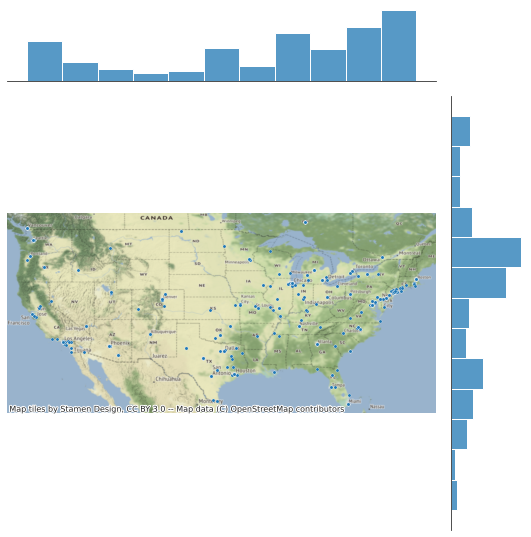

In [68]:
# add a basemap to jointplots
# scatterplot with edges
sns.set_style('white')
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  s=10,
                  height=8 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

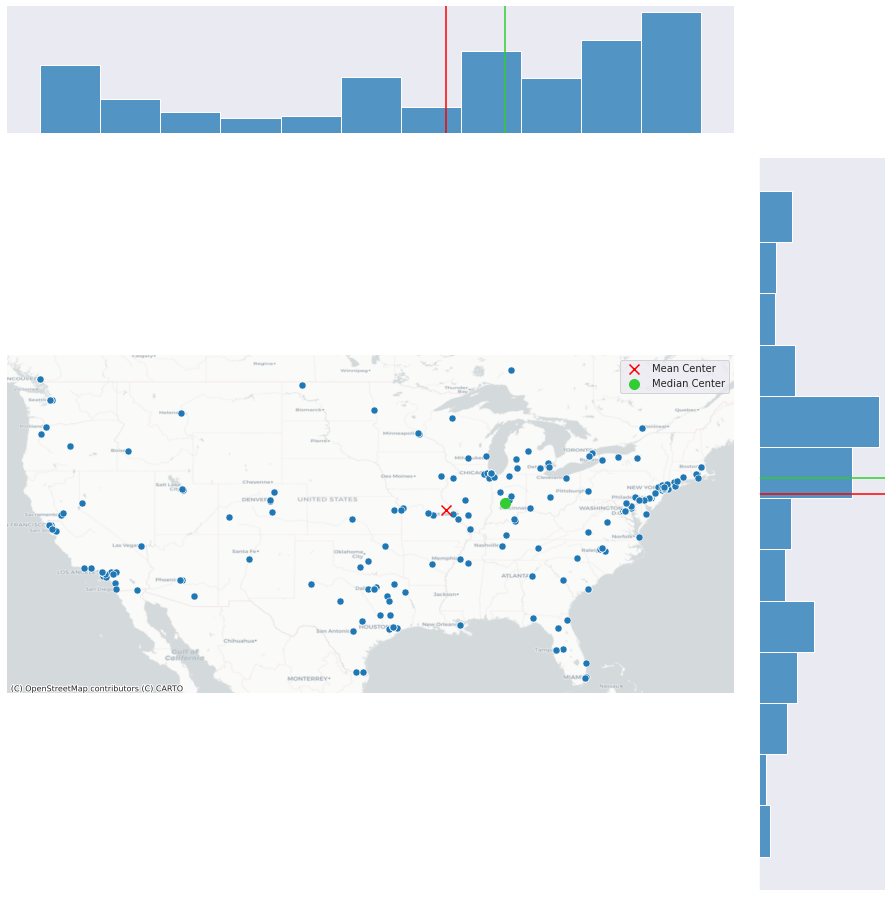

In [89]:
# Generate scatter plot

g = sns.jointplot(
    x='x', y='y', data=gdf, s=50, height=13,
)

# Add mean point and marginal lines
g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=100, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=100, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='limegreen')
g.ax_marg_y.axhline(med_center[1], color='limegreen')

# Legend
g.ax_joint.legend()

# Add basemap
ctx.add_basemap(
    g.ax_joint, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

# Clean axes
g.ax_joint.set_axis_off()

# Display
plt.show()


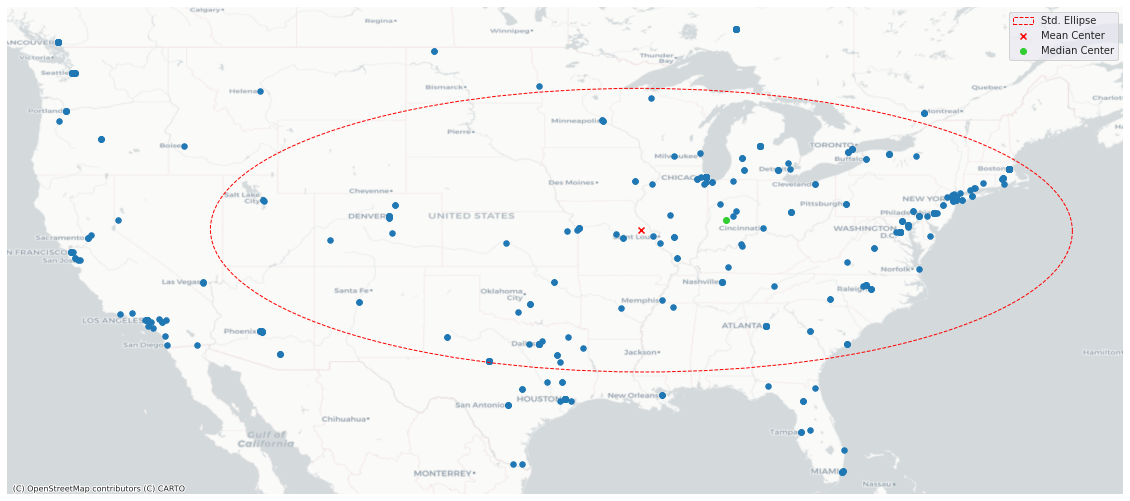

In [90]:
major, minor, rotation = centrography.ellipse(gdf[['x','y']])
mean_center = centrography.mean_center(gdf[['x','y']])
med_center = centrography.euclidean_median(gdf[['x','y']])
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(20, 20))

# Plot points
ax.scatter(gdf['x'], gdf['y'], s=30)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

# add a basemap
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

# Display
plt.show()

In [94]:
gdf_pos = gdf.query("compound_sentiment > 0.25")
gdf_neg = gdf.query("compound_sentiment < -0.25")

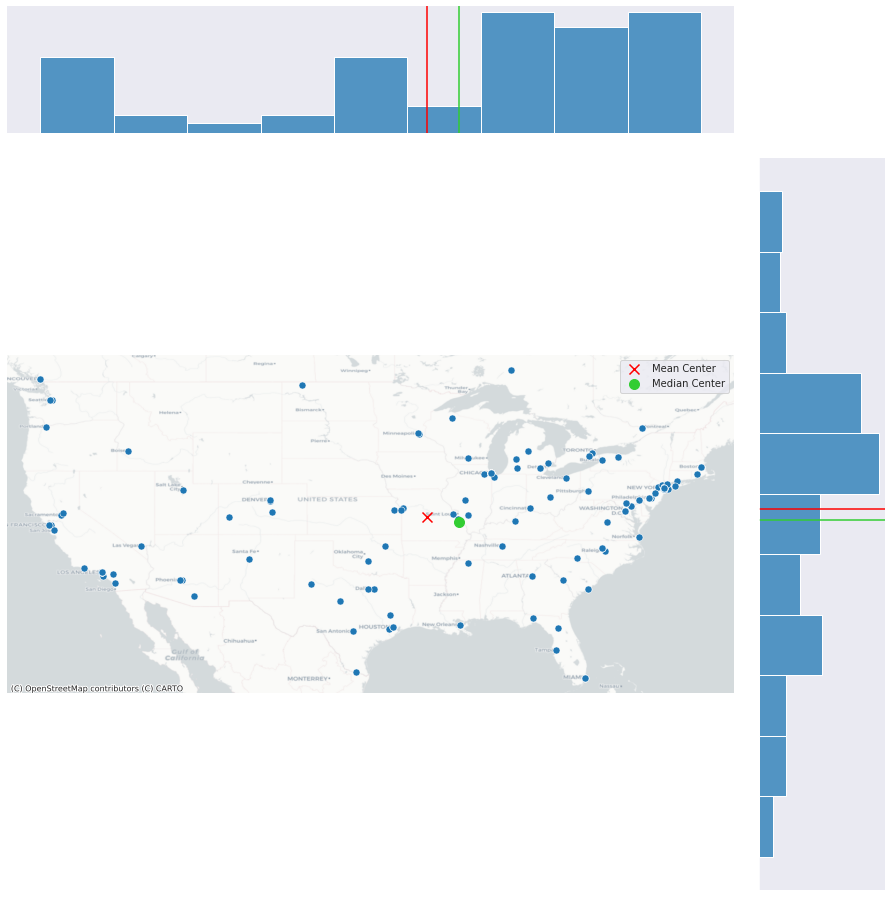

In [97]:
# Generate scatter plot

g = sns.jointplot(
    x='x', y='y', data=gdf_pos, s=50, height=13,
)

# Add mean point and marginal lines
g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=100, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=100, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='limegreen')
g.ax_marg_y.axhline(med_center[1], color='limegreen')

# Legend
g.ax_joint.legend()

# Add basemap
ctx.add_basemap(
    g.ax_joint, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

# Clean axes
g.ax_joint.set_axis_off()

# Display
plt.show()


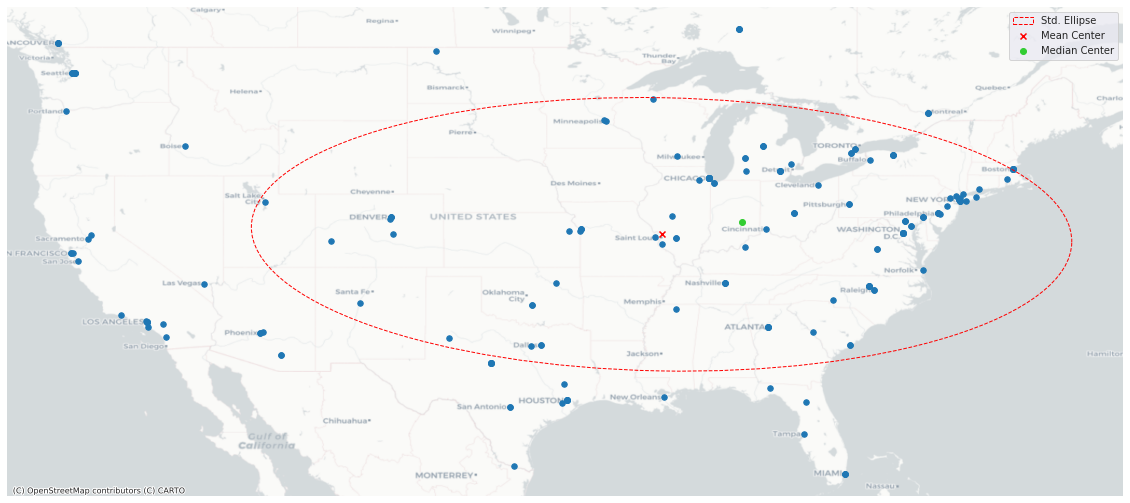

In [95]:
major, minor, rotation = centrography.ellipse(gdf_pos[['x','y']])
mean_center = centrography.mean_center(gdf_pos[['x','y']])
med_center = centrography.euclidean_median(gdf_pos[['x','y']])
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(20, 20))

# Plot points
ax.scatter(gdf_pos['x'], gdf_pos['y'], s=30)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

# add a basemap
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

# Display
plt.show()

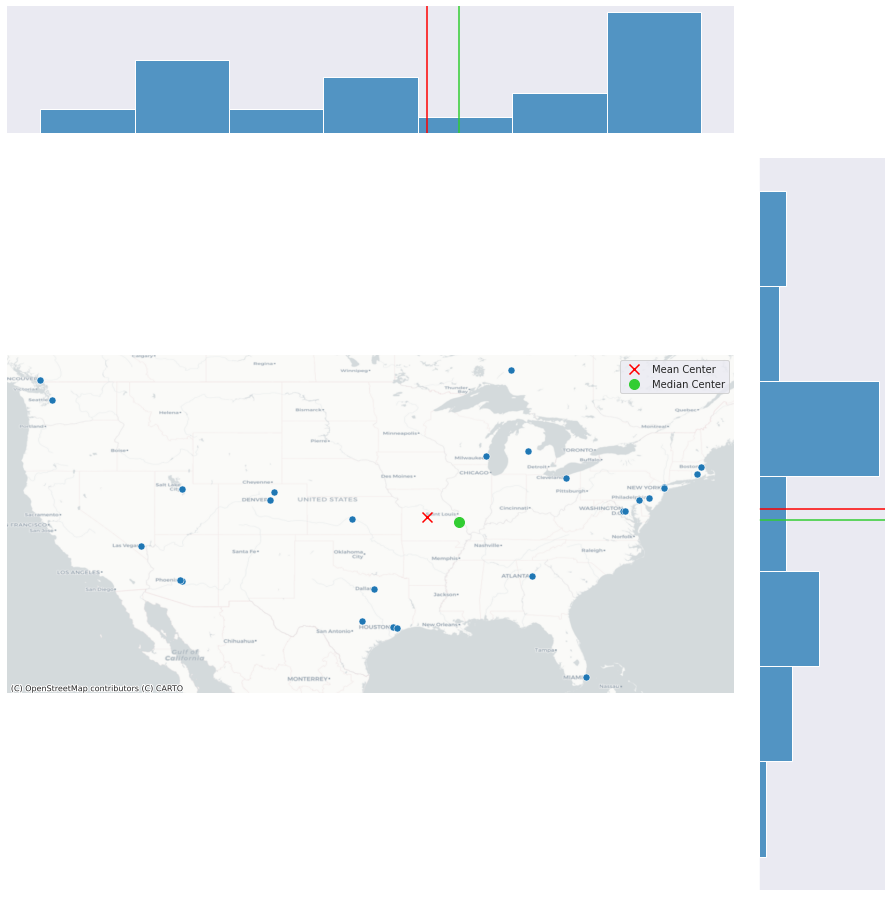

In [98]:
# Generate scatter plot

g = sns.jointplot(
    x='x', y='y', data=gdf_neg, s=50, height=13,
)

# Add mean point and marginal lines
g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=100, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=100, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='limegreen')
g.ax_marg_y.axhline(med_center[1], color='limegreen')

# Legend
g.ax_joint.legend()

# Add basemap
ctx.add_basemap(
    g.ax_joint, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

# Clean axes
g.ax_joint.set_axis_off()

# Display
plt.show()


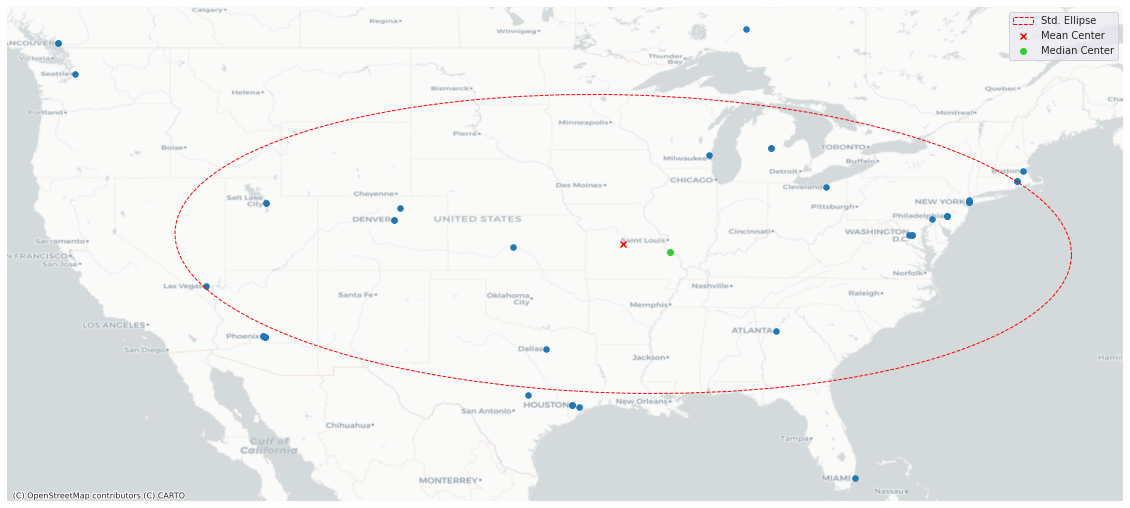

In [96]:
major, minor, rotation = centrography.ellipse(gdf_neg[['x','y']])
mean_center = centrography.mean_center(gdf_neg[['x','y']])
med_center = centrography.euclidean_median(gdf_neg[['x','y']])
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(20, 20))

# Plot points
ax.scatter(gdf_neg['x'], gdf_neg['y'], s=30)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

# add a basemap
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

# Display
plt.show()